In [1]:
%load_ext autoreload
%autoreload 2

from data_prep import DataPreparation, filtering_data
from lstm import LSTMModelTrainerAttention, LSTMRollingForecaster
from rf import RandomForestTrainer
from lgbm import LightGBMTrainer
from catboost_trainer import CatBoostTrainer
from transformer import TransformerTrainer
import os
import dill as pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings("ignore", category=UserWarning)


c:\Users\iLabs_6\anaconda3\envs\texml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output= r'C:\Users\iLabs_6\Documents\Tex\realtimetest'
modelname = 'extended_ATOT_RT'

 
with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_df = pickle.load(f)

extended_df['cap_DEP'].fillna(extended_df['cap_DEP'].mean(), inplace=True)
extended_df['cap_DES'].fillna(extended_df['cap_DES'].mean(), inplace=True)
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_eobt', case=False)]
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_atot', case=False)]

pd.set_option("display.max_columns", None)
X, y, colnames = filtering_data(extended_df, airport ='EHAM', save=True)
X = X.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
X.describe()

output= r'C:\Users\iLabs_6\Documents\Tex\realtimetest'
modelname = 'extended_ETOT_RT'


with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_real= pickle.load(f)
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_eobt', case=False)]
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_atot', case=False)]

pd.set_option("display.max_columns", None)
print(f'{extended_real}')
X_r, y_r, colnames = filtering_data(extended_real, airport ='EHAM', save=False)
X_r = X_r.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
# X.fillna(0, inplace=True)
print(f'xxxxx = {X_r}')

           distance                ETOT  ADEP  ADES                EOBT  \
0       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
1       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
2       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
3       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
4       1992.934496 2024-03-01 14:03:00  LFLL  EHAM 2024-03-01 13:55:00   
...             ...                 ...   ...   ...                 ...   
26679  15512.634974 2024-03-25 17:35:00  LFPG  EHAM 2024-03-25 17:15:00   
26680  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   
26681  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   
26682  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   
26683  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   

                      ETA    CDMStatus  taxitime event  regulations  \
0     2024-03-01 09:48:00  D

In [14]:
data_prep = DataPreparation()


X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, time_horizons, cbaslabels = data_prep.fit_transform_data(X, y)
X_real, ETOT_horizons, cbaslabels = data_prep.transform_data(X_r)

X_train, X_test, y_train, y_test = data_prep.fit_transform_data(X, y, split_ratio=0.8, mode='rf')
print(f'{X_train_tensor.shape=}')
print(f'{X_test_tensor.shape=}')

skip=['CBAS', 'cbas', 'eobt', 'atot']
time_varying_columns=['atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'wspeed_Tmin_-300', 'wdirec_Tmin_-300', 'wguts_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'wspeed_Tmin_-295', 'wdirec_Tmin_-295', 'wguts_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 'a

X_train_tensor.shape=torch.Size([70142, 61, 82])
X_test_tensor.shape=torch.Size([17536, 61, 82])
device = cuda
params = (82, 50, 1, 3, 0.0005, 40, 1, 5, 0.2)
Start training with model varattention
Epoch 1: Current max_shift = 2
Epoch [1/40], Train Loss: 0.4542, Val Loss: 0.4601
Epoch 2: Current max_shift = 2
Epoch [2/40], Train Loss: 0.3748, Val Loss: 0.3919
Epoch 3: Current max_shift = 2
Epoch [3/40], Train Loss: 0.3163, Val Loss: 0.3625
Epoch 4: Current max_shift = 2
Epoch [4/40], Train Loss: 0.2962, Val Loss: 0.3450
Epoch 5: Current max_shift = 2
Epoch [5/40], Train Loss: 0.2837, Val Loss: 0.3306
Epoch 6: Current max_shift = 2
Epoch [6/40], Train Loss: 0.2766, Val Loss: 0.3209
Epoch 7: Current max_shift = 2
Epoch [7/40], Train Loss: 0.2702, Val Loss: 0.3202
Epoch 8: Current max_shift = 2
Epoch [8/40], Train Loss: 0.2653, Val Loss: 0.3123
Epoch 9: Current max_shift = 2
Epoch [9/40], Train Loss: 0.2607, Val Loss: 0.3180
Epoch 10: Current max_shift = 2
Epoch [10/40], Train Loss: 0.2554

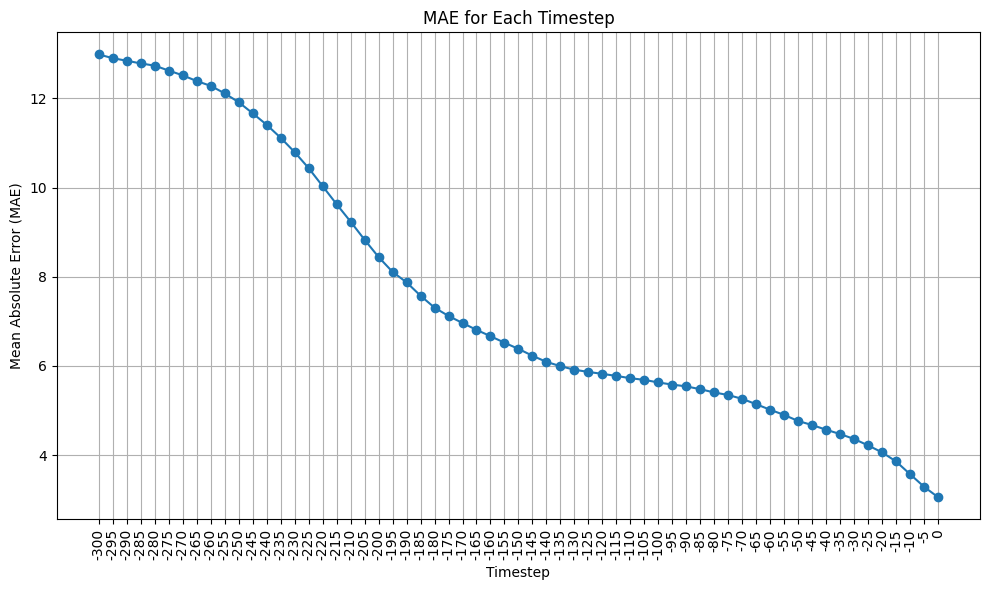

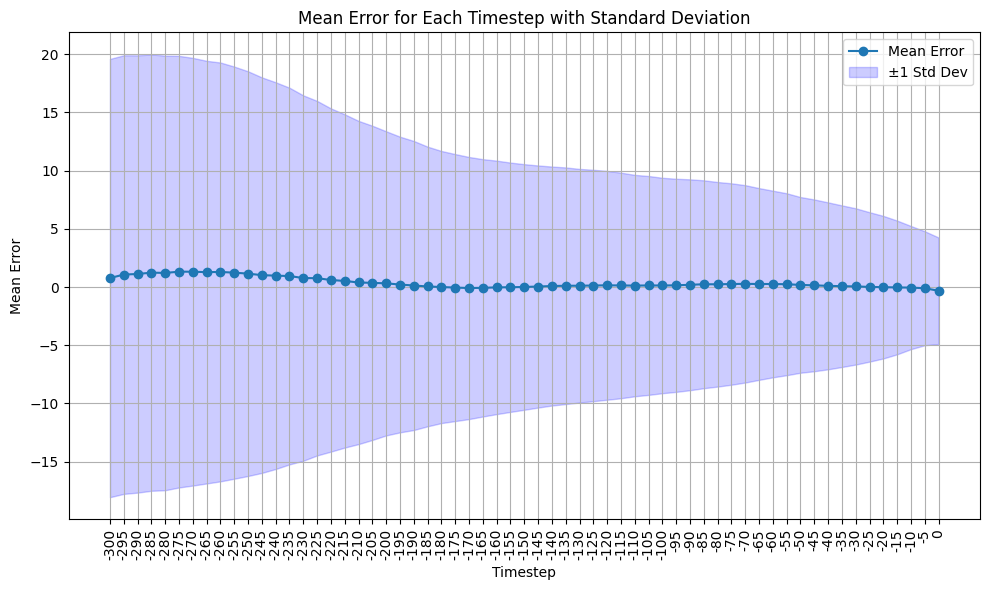

In [4]:
model_trainer = LSTMModelTrainerAttention(data_prep=data_prep, input_size=data_prep.input_size, model_type='varattention')
print(f'{X_train_tensor.shape=}')
print(f'{X_test_tensor.shape=}')
# Set data loaders
model_trainer.set_data_loaders(data_prep.train_loader, data_prep.test_loader, data_prep.time_steps)

# ANDERE SWITCH, afhankelijk van eerste prediction
best_model = model_trainer.hyperparameter_search(1)
#2707 16 it
# Evaluate the best model and plot the results
y_pred, y_test = model_trainer.evaluate_and_plot(best_model, X_test_tensor, y_test_tensor, data_prep.scaler_y, time_horizons)

#2536

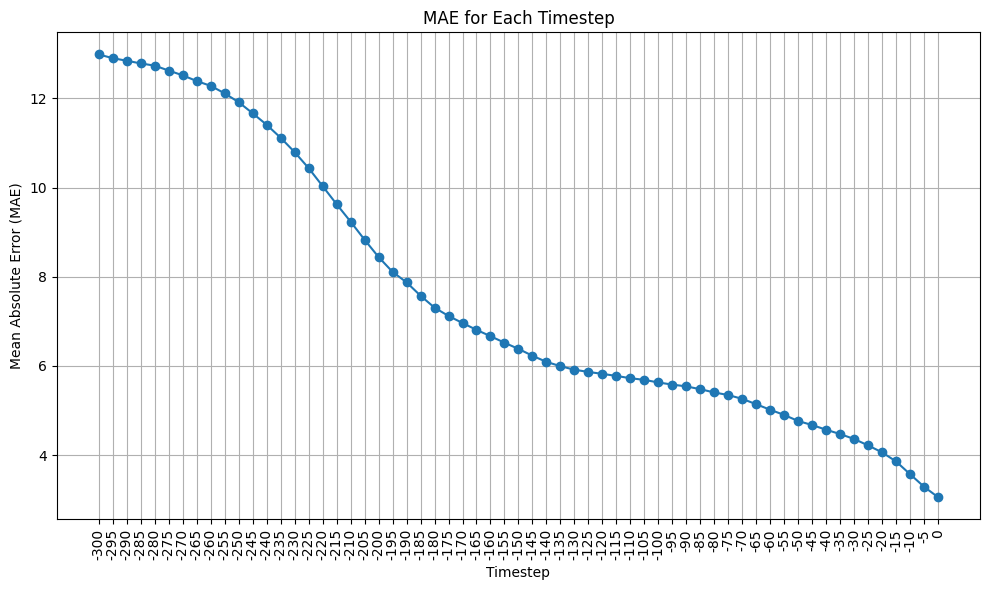

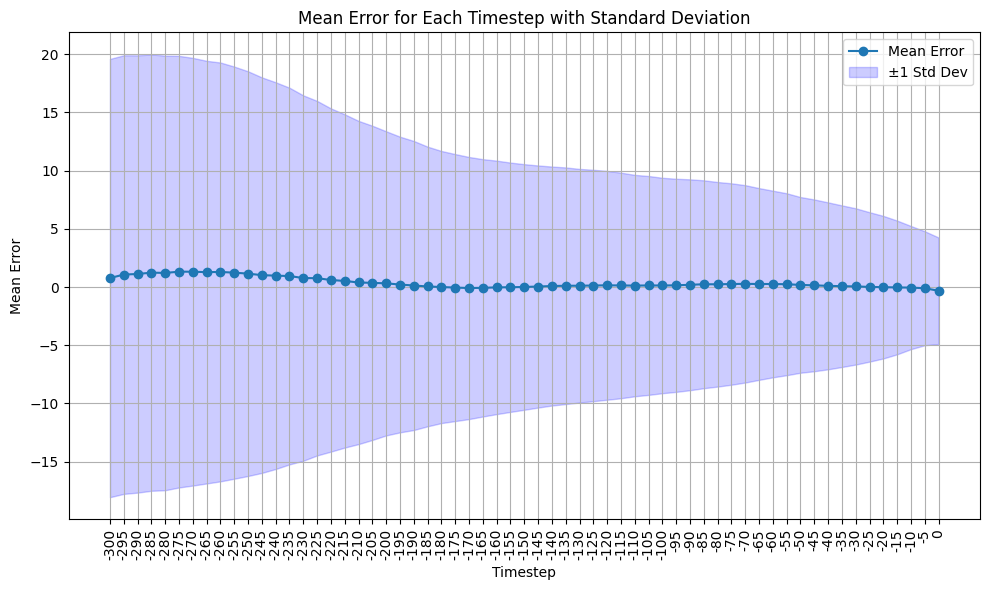

In [5]:
y_pred, y_test = model_trainer.evaluate_and_plot(best_model, X_test_tensor, y_test_tensor, data_prep.scaler_y, time_horizons)


In [6]:
output= r"C:\Users\iLabs_6\Documents\Tex\AirTrafficDelays\LSTM_Models"

modelname = 'lstm-9-100-2shift-2111lars'
with open(os.path.join(output, modelname), 'wb') as f:  
    pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"FlightDataset has been saved successfully. {modelname}")

with  open(os.path.join(output, modelname), 'rb') as f:  
    best_model = pickle.load(f)


FlightDataset has been saved successfully. lstm-9-100-2shift-2111lars


In [7]:
# Initialize RandomForestTrainer with desired hyperparameters
trainer_rf = RandomForestTrainer(dataprep=data_prep, horizons=data_prep.time_horizons)

# # Share the scaler_y between data_prep_rf and trainer_rf
trainer_rf.scaler_y = data_prep.scaler_y

# # Train the model
trainer_rf.train(X_train, y_train)


--- Training Random Forest for Timestep -300 ---
Performing hyperparameter search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters for Timestep -300: {'n_estimators': 200, 'max_samples': 0.8, 'max_features': 0.7, 'max_depth': 20, 'bootstrap': True}
Timestep -300 - Training MSE: 140.6382, Training MAE: 8.3323
Saved model for Timestep -300 at C:\Users\iLabs_6\Documents\Tex\rf\rf_-300.pkl

--- Training Random Forest for Timestep -295 ---
Performing hyperparameter search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters for Timestep -295: {'n_estimators': 200, 'max_samples': 0.8, 'max_features': 0.7, 'max_depth': 20, 'bootstrap': True}
Timestep -295 - Training MSE: 141.2692, Training MAE: 8.3655
Saved model for Timestep -295 at C:\Users\iLabs_6\Documents\Tex\rf\rf_-295.pkl

--- Training Random Forest for Timestep -290 ---
Performing hyperparameter search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters f

In [9]:
trainer_rf.evaluate(X_test, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [1069696, 17536]

In [17]:
trainer_gbm = LightGBMTrainer(dataprep=data_prep,n_estimators=20, max_depth=10, min_samples_split=5, horizons=data_prep.time_horizons)

# Share the scaler_y between data_prep_rf and trainer_rf
trainer_gbm.scaler_y = data_prep.scaler_y

# Train the model
trainer_gbm.train(X_train, y_train)

Model directory already exists at: lgbm_models

--- Training LightGBM for Timestep -300 ---
Performing hyperparameter search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2774
[LightGBM] [Info] Number of data points in the train set: 70142, number of used features: 76
[LightGBM] [Info] Start training from score 0.006468
Best Parameters for Timestep -300: {'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 1, 'num_leaves': 70, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Timestep -300 - Training MSE: 223.0642, Training MAE: 10.3391
Saved model for Timestep -300 at lgbm_models\lgbm_-300.pkl

--- Training LightGBM for Timestep -295 ---
Performing hyperparamete

Loaded model for Timestep -300 from lgbm_models\lgbm_-300.pkl
Loaded model for Timestep -295 from lgbm_models\lgbm_-295.pkl
Loaded model for Timestep -290 from lgbm_models\lgbm_-290.pkl
Loaded model for Timestep -285 from lgbm_models\lgbm_-285.pkl
Loaded model for Timestep -280 from lgbm_models\lgbm_-280.pkl
Loaded model for Timestep -275 from lgbm_models\lgbm_-275.pkl
Loaded model for Timestep -270 from lgbm_models\lgbm_-270.pkl
Loaded model for Timestep -265 from lgbm_models\lgbm_-265.pkl
Loaded model for Timestep -260 from lgbm_models\lgbm_-260.pkl
Loaded model for Timestep -255 from lgbm_models\lgbm_-255.pkl
Loaded model for Timestep -250 from lgbm_models\lgbm_-250.pkl
Loaded model for Timestep -245 from lgbm_models\lgbm_-245.pkl
Loaded model for Timestep -240 from lgbm_models\lgbm_-240.pkl
Loaded model for Timestep -235 from lgbm_models\lgbm_-235.pkl
Loaded model for Timestep -230 from lgbm_models\lgbm_-230.pkl
Loaded model for Timestep -225 from lgbm_models\lgbm_-225.pkl
Loaded m

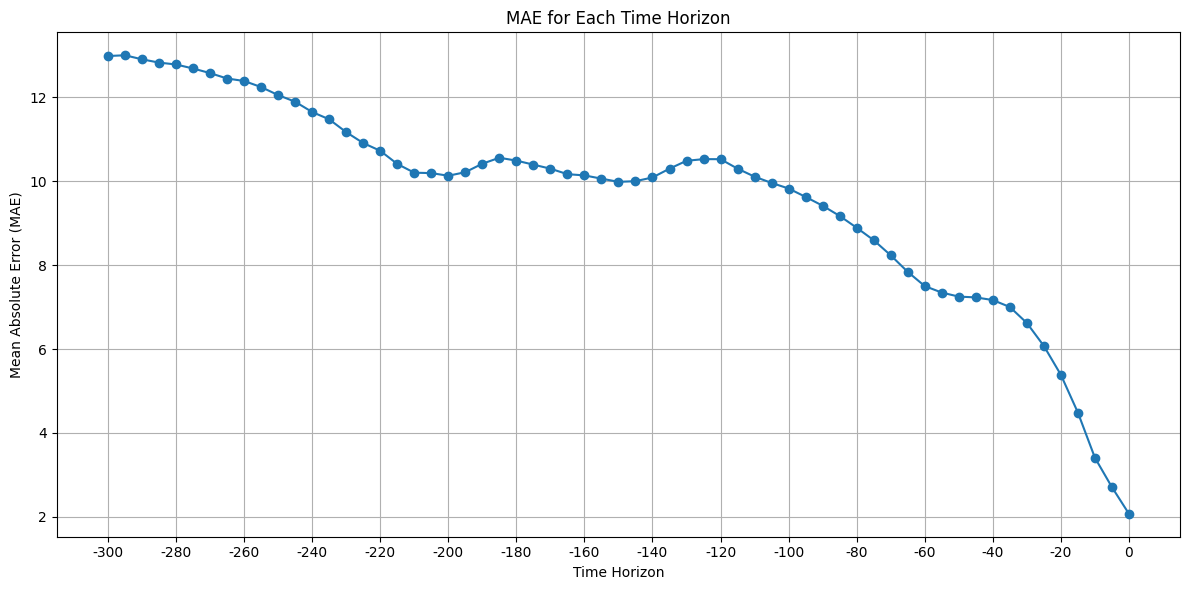

[12.987722873866911,
 13.006057085984741,
 12.909249223277035,
 12.831140405781454,
 12.78608117570033,
 12.69064349981162,
 12.580779720341436,
 12.451699423204193,
 12.392550968740675,
 12.247902110256053,
 12.056741725290387,
 11.897546601613069,
 11.65306734281696,
 11.47859908773334,
 11.17295522426898,
 10.912820677045433,
 10.72843760313716,
 10.414561800329086,
 10.205598735804548,
 10.196284079621943,
 10.132979431739491,
 10.217924767109631,
 10.419841446476966,
 10.561754695791596,
 10.4940094119526,
 10.397953087185092,
 10.30153479552454,
 10.17062547191665,
 10.14127398295942,
 10.063861229117354,
 9.98753181041285,
 10.003181538903702,
 10.092055135749048,
 10.301574819178782,
 10.489684889931128,
 10.528992345418112,
 10.52799382604803,
 10.302073780274936,
 10.110679565731843,
 9.961469921448538,
 9.828893006363389,
 9.628086027741315,
 9.417936414787249,
 9.174785792738788,
 8.893041401425805,
 8.596374000421598,
 8.23582511926112,
 7.84078806897718,
 7.50211126052458

In [18]:
trainer_gbm.evaluate(X_test, y_test)

In [ ]:
trainer_cat = CatBoostTrainer(dataprep=data_prep, horizons=data_prep.time_horizons)

# Share the scaler_y between data_prep_rf and trainer_rf
trainer_cat.scaler_y = data_prep.scaler_y

# Train the model
trainer_cat.train(X_train, y_train)

Model directory already exists at: catboost_models


Loaded model for Timestep -300 from catboost_models\catboost_-300.pkl
Loaded model for Timestep -295 from catboost_models\catboost_-295.pkl
Loaded model for Timestep -290 from catboost_models\catboost_-290.pkl
Loaded model for Timestep -285 from catboost_models\catboost_-285.pkl
Loaded model for Timestep -280 from catboost_models\catboost_-280.pkl
Loaded model for Timestep -275 from catboost_models\catboost_-275.pkl
Loaded model for Timestep -270 from catboost_models\catboost_-270.pkl
Loaded model for Timestep -265 from catboost_models\catboost_-265.pkl
Loaded model for Timestep -260 from catboost_models\catboost_-260.pkl
Loaded model for Timestep -255 from catboost_models\catboost_-255.pkl
Loaded model for Timestep -250 from catboost_models\catboost_-250.pkl
Loaded model for Timestep -245 from catboost_models\catboost_-245.pkl
Loaded model for Timestep -240 from catboost_models\catboost_-240.pkl
Loaded model for Timestep -235 from catboost_models\catboost_-235.pkl
Loaded model for Tim

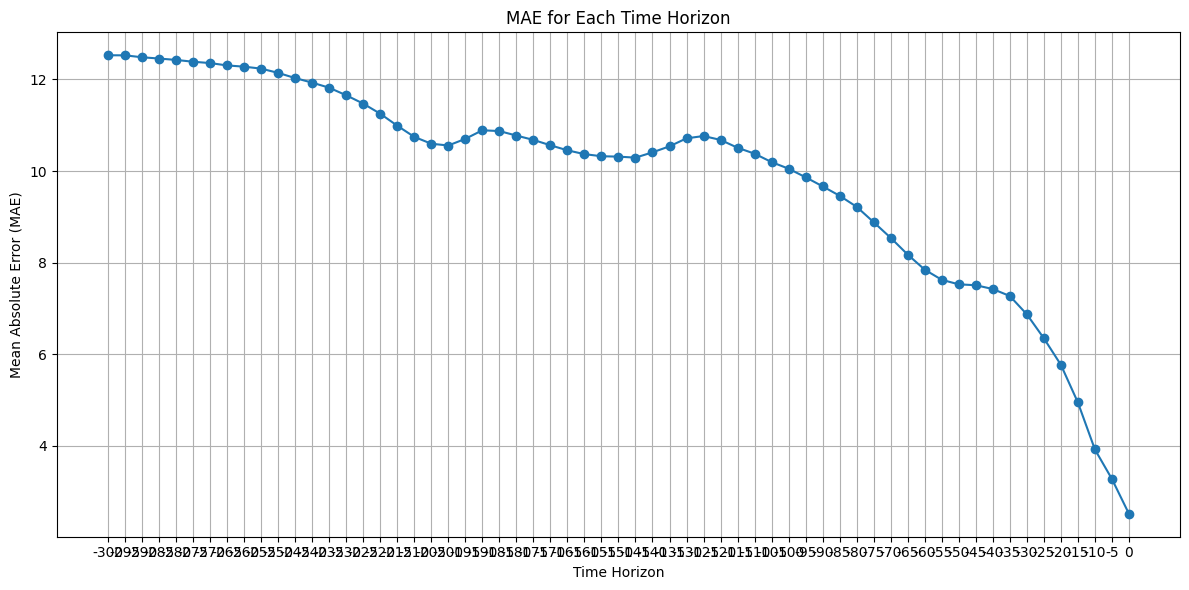

[12.528761491717882,
 12.52704123253812,
 12.485254169013496,
 12.457222695756794,
 12.426888719149186,
 12.387403312837861,
 12.358205376670208,
 12.306657214836433,
 12.279813001485621,
 12.236684270354337,
 12.144186769618456,
 12.030633646244448,
 11.930892912036251,
 11.819782157078256,
 11.654865288786334,
 11.472780534385535,
 11.251733417093702,
 10.990335360970256,
 10.7459628752551,
 10.596474926143916,
 10.55750920095829,
 10.702831902008642,
 10.889916524197774,
 10.873347907106345,
 10.774636839424167,
 10.680114697358066,
 10.562516603754753,
 10.452334124205883,
 10.369087394907812,
 10.323228165236994,
 10.314376297267376,
 10.29251184018139,
 10.407865620044547,
 10.539619502020265,
 10.714188221695188,
 10.764599610159776,
 10.679658479789628,
 10.508692982130928,
 10.378927981843741,
 10.194930918934661,
 10.051083145686016,
 9.863460529263666,
 9.665388489697166,
 9.459341754086212,
 9.218166125046004,
 8.88218633218284,
 8.540313938436602,
 8.17442877184843,
 7.844

In [ ]:
trainer_cat.evaluate(X_test, y_test)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70142, 61, 82), (17536, 61, 82), (70142, 1), (17536, 1))